### What is Synthetic Control for Causal Inference?

Synthetic control is a method used in causal inference to estimate the effect of an intervention or treatment when a traditional randomized controlled trial is not feasible. It is particularly useful in observational studies where the treatment is applied to a single unit (e.g., a country, a state, a company) and there is no obvious control group for comparison.

The basic idea is to construct a "synthetic" control group by taking a weighted combination of untreated units (e.g., other countries, states, or companies) that approximates the characteristics of the treated unit before the intervention. The effect of the intervention is then estimated by comparing the post-intervention outcomes of the treated unit with the outcomes of the synthetic control.

### Key Steps in Synthetic Control

1. **Selection of Donor Pool**: Identify a set of potential control units (the donor pool) that did not receive the treatment.
2. **Pre-Treatment Matching**: Use a weighted combination of the units in the donor pool to construct a synthetic control that closely matches the treated unit on pre-treatment characteristics and outcomes.
3. **Estimation of Treatment Effect**: Compare the post-treatment outcomes of the treated unit with the synthetic control to estimate the causal effect of the intervention.

### Example of Synthetic Control: Effect of cigarette taxation

[Based on example from the book Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html)

In 1988, California passed the Tobacco Tax and Health Protection Act, a landmark legislation aimed at reducing tobacco consumption through increased taxes on cigarette sales. This act not only imposed a significant tax on cigarettes and other tobacco products but also allocated the revenue towards health education, disease prevention, and tobacco-related research programs. The initiative marked a pivotal step in public health policy, setting a precedent for other states and countries in their efforts to combat the adverse health effects associated with tobacco use.

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the year 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.


#### Step 1: Prepare the Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
url = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv"

cigar = pd.read_csv(url)
cigar.query("california").head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
62,3,1970,123.000000,NaN,NaN,0.178158,38.799999,True,False
63,3,1971,121.000000,NaN,NaN,0.179296,39.700001,True,False
64,3,1972,123.500000,9.930814,NaN,0.180434,39.900002,True,False
65,3,1973,124.400002,9.955092,NaN,0.181572,39.900002,True,False
66,3,1974,126.699997,9.947999,NaN,0.182710,41.900002,True,False


In our data, we have:  
*Covariates:* 
- `state` as the state index
- `retprice` as the cigarette retail price

*Treatment:*
- `california`: boolean for the state of california
- `after_treatment` : true/false for post intervention period

*Outcome:*
- `cigsale` the per capita sales of cigarettes in packs


##### Plot: Per-capita cigarette sales in California and others

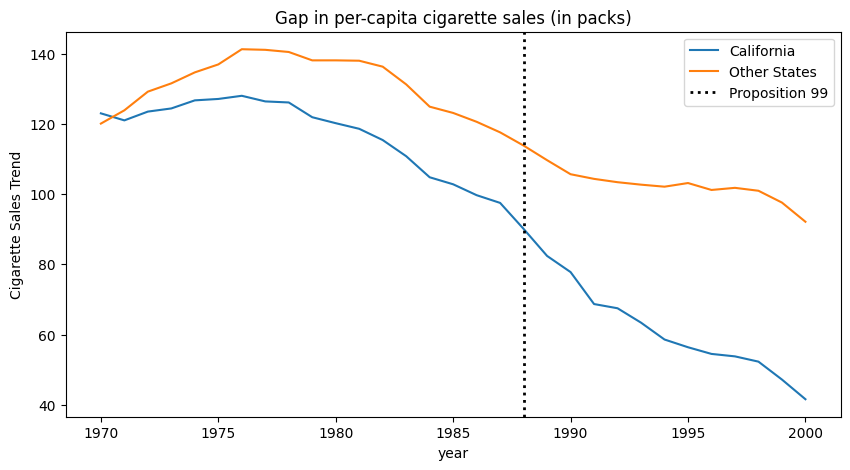

In [5]:
# Assuming 'cigar' is your DataFrame
fig, ax = plt.subplots(figsize=(10, 5))

(cigar
 .assign(california=lambda x: np.where(x["california"], "California", "Other States"))
 .groupby(["year", "california"])["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax))

plt.axvline(x=1988, ymin=0, ymax=1, linestyle=":", lw=2, color='black', label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend()
plt.show()


During the time for which we have data, people in California apparently bought less cigarettes than the national average. Also, it appears to be a decreasing movement in cigarette consumption after the 80s. It looks like after Proposition 99 the decreasing trend accelerated for California, compared to other states, but we can’t say that for sure. It is just a guess that we have by examining the plot.



#### Step 2: Construct Synthetic Control
To answer the question of whether Proposition 99 had an effect on cigarette consumption, we will use the pre-intervention period to build a synthetic control. We will combine the other states to build a fake state that resembles very closely the trend of California. Then, we will see how this synthetic control behaves after the intervention.

We need to find weights for the control units that minimize the difference between the treated unit and the weighted combination of controls in the pre-treatment period.

To do this with linear regression, we will find the weight using OLS. We will minimise the square distance between the weighted average of the units in the donor pool and the treated unit for the pre-intervention period.

In [6]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

Next, we can define our Y variable as the state of California and the X as the other states.

In [7]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [13]:
from sklearn.linear_model import LinearRegression

# Fit regression model to find weights
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
weights_lr = model.coef_
weights_lr.round(3)


array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

These weights show us how to build the synthetic control. 

In [14]:
# Create synthetic control
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

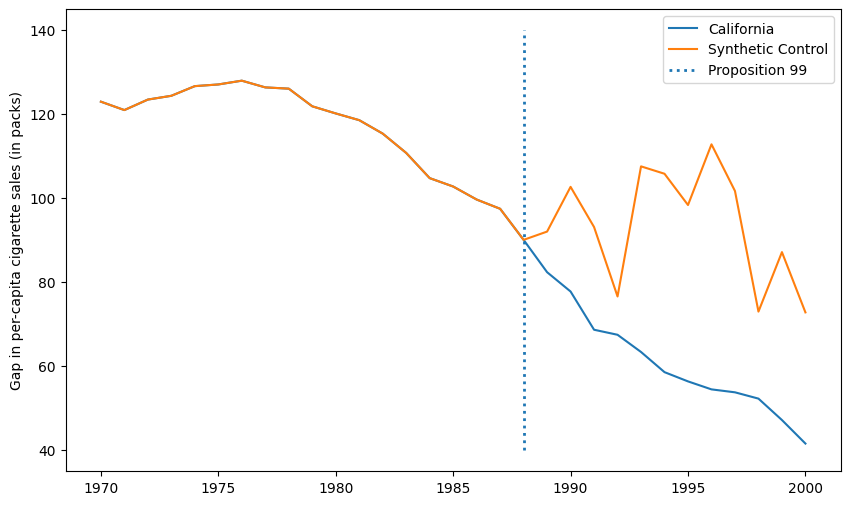

In [15]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

We have 38 states in our donor pool, so our linear regressio model overfitted the treatment state. Overfitting also caused more variance on the outcome variable after the intervention.  
Instead, let's try using interpolation where the weights should sum up to 1.

In [16]:
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp


def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))


def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [17]:
# New weights
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

Now, we get the adjusted synthetic control

In [18]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

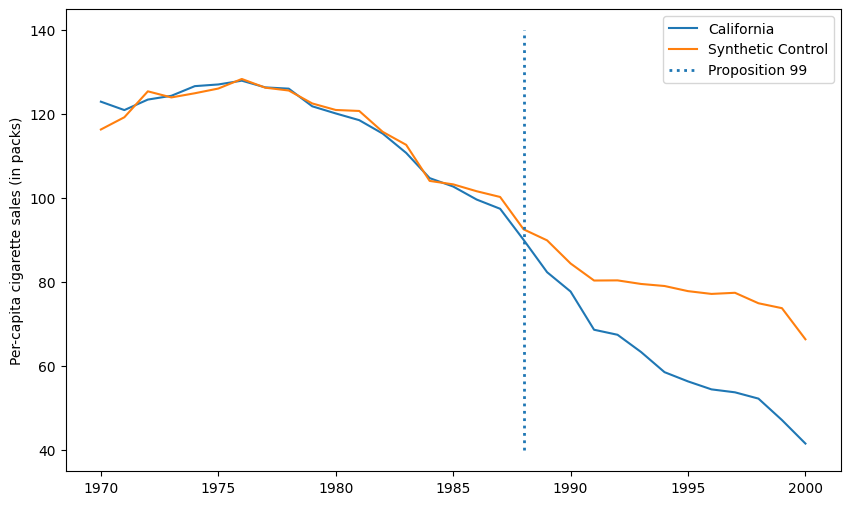

In [19]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

#### Step 3: Estimate the Treatment Effect

With the synthetic control at hand, we can estimate the treatment effect as the gap between treated and the synthetic control outcomes.

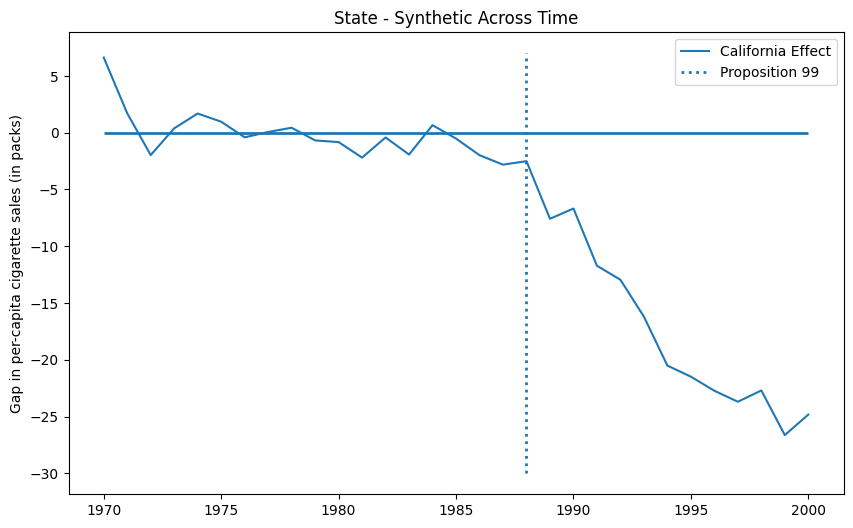

In [20]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();


#### Step 4. Making Inference

In [21]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [22]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


In [23]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [24]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


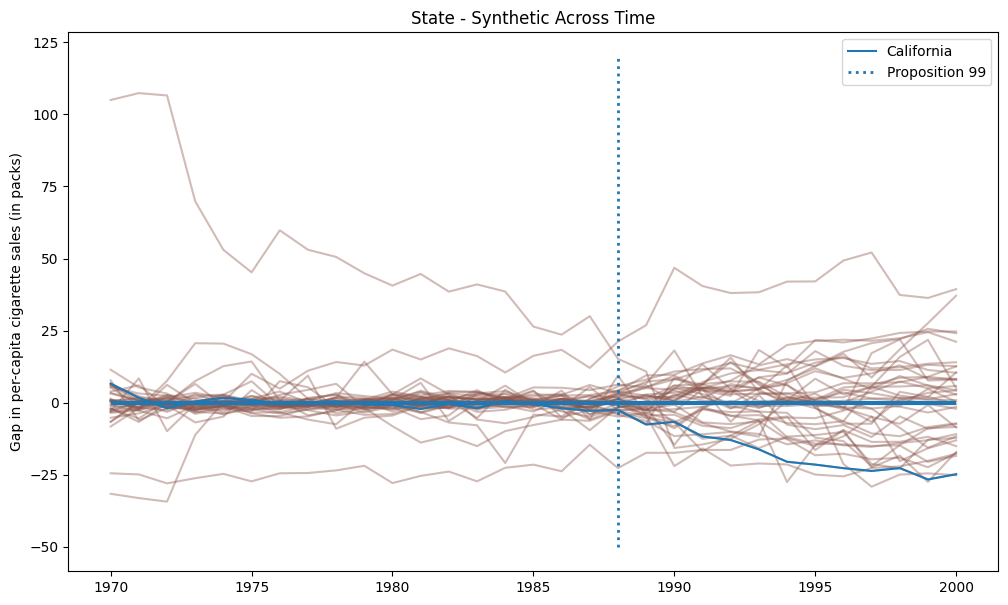

In [25]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

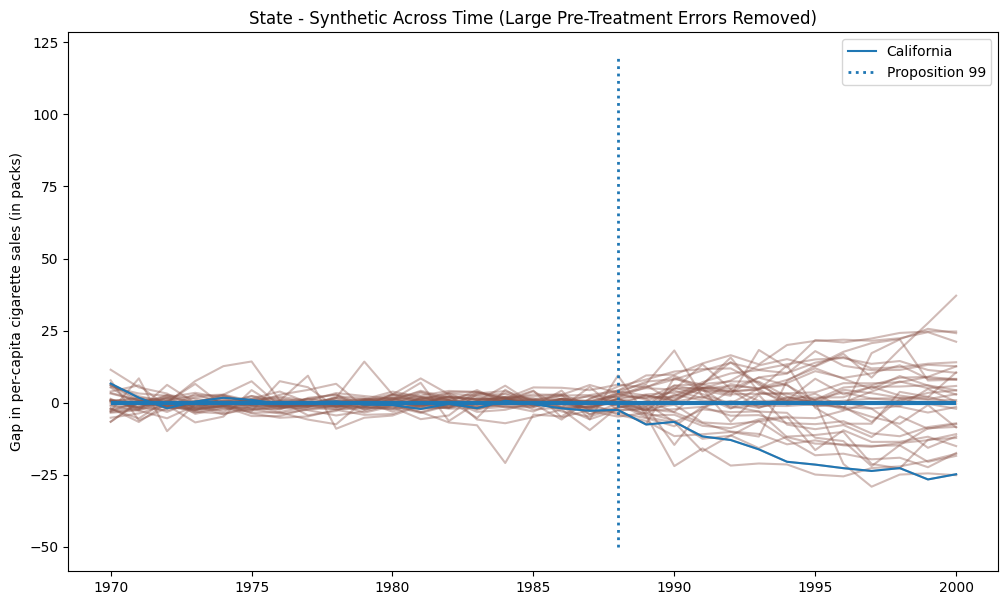

In [26]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

In [32]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects).round(2)

California Treatment Effect for the Year 2000: -24.83015975607075


array([  5.8 ,   0.89, -24.83,  -7.17, -10.92,  37.12, -15.07,  -0.5 ,
       -18.46,  21.13,  12.58,  -1.48,  10.5 , -11.67,   4.3 ,   8.05,
        14.02,   8.25,   0.33,  -8.41,  -2.12,  -7.43,   2.96,  24.1 ,
         4.25, -17.76,   7.93,   2.82,  12.65, -17.48, -25.16, -12.26,
        24.69,  10.36,  -8.6 ])

In [33]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

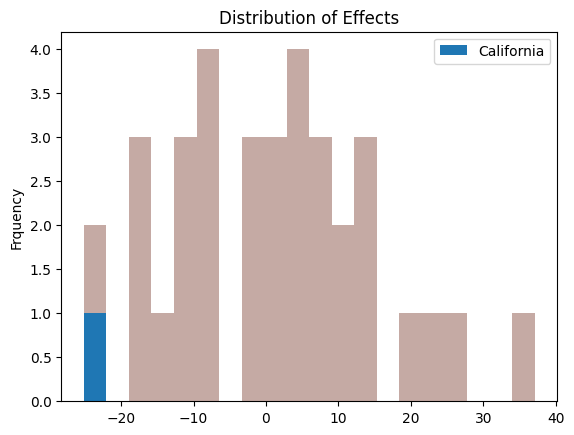

In [34]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

### Conclusion
The synthetic control method is a powerful tool for causal inference in observational studies, especially when dealing with a single treated unit. By constructing a synthetic control from a combination of untreated units that closely resembles the treated unit in the pre-treatment period, researchers can estimate the causal effect of an intervention more reliably.